# SC1015 Mini-Project: Laptop Price

### Class: PT3
### Team : F
### Teammates: Jia Ze (U2120155G), Tan Choon Wee (U2120106H), Zaw Won Na Ko Ko (U2120885B)


In [204]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

## Import the Dataset

The dataset is in CSV format; hence we use the read_csv function from Pandas.
Immediately after importing, take a quick look at the data using the head function.

In [205]:
laptopData = pd.read_csv('laptop pricing.csv', encoding='ISO-8859-1')
laptopData.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [206]:
laptopData.shape

(1303, 13)

In [207]:
laptopData.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [208]:
laptopData.dtypes

laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price_euros         float64
dtype: object

In [209]:
laptopData.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

# Observation from the dataset

1. There are 1303 row entries with 13 Columns
2. 10 columns are category type while the rest 3 columns ("laptop_ID"，“Inches" & "Price_euros") are numerical type.
3. There is no NULL entry found

# Data Cleaning

Prior Uni/Bivariate Analysis, data cleaning will be performed to remove unnecessary strings

### 1, we drop unnecessary factors such as "laptop_ID" & "Product", and keep "Company", "TypeName" & "Inches" unchanged

In [210]:
laptopData.drop(['laptop_ID', 'Product'], axis = 1,inplace=True)

In [211]:
laptopData.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


### 2, Data Cleaning for ScreenResolution

In [212]:
# Get touchscreen data from Screen Resolution Column
laptopData['Touchscreen'] = laptopData['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
laptopData['Touchscreen'] =laptopData["Touchscreen"].astype(object)

# Remove Text and obtain Screen resolution Only
new = laptopData["ScreenResolution"].str.split("x", n = 1, expand = True) 
laptopData["X_res"]= new[0]
laptopData["Y_res"]= new[1]
laptopData["Y_res"]= pd.to_numeric(laptopData["Y_res"])
laptopData["Y_res"]= laptopData["Y_res"].astype(float)
laptopData["X_res"]=(laptopData['X_res'].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x: pd.Series(x).astype(int)).mean(1))
laptopData["X_res"]=pd.to_numeric(laptopData["X_res"])
laptopData["ScreenResolution"]=(laptopData["X_res"]*laptopData["Y_res"]).astype(float)

# Convert the resolution to Pixel Per inch (PPI) as this is easier to analyse, and this will be useful when comparing different screen sizes 
laptopData['PPI']=(((laptopData["X_res"]**2+laptopData["Y_res"]**2)**(1/2))/laptopData["Inches"]).astype(float)

### 3, Data Cleaning for CPU

In [213]:
laptopData["Cpu_Speed"] = laptopData["Cpu"].str.split(" ").apply(lambda x: x[-1]).str.replace("GHz", "")
laptopData['Cpu_Speed'] =laptopData["Cpu_Speed"].astype(float)
laptopData["Cpu_Vender"] = laptopData["Cpu"].str.split(" ").apply(lambda x: x[0])
laptopData["Cpu_Type"] = laptopData["Cpu"].str.split(" ").apply(lambda x: x[1:4] if x[1] == "Celeron" and "Pentium" and "Xeon" else (x[1:3] if (x[1] == "Core" or x[0] == "AMD") else x[0]) )
laptopData["Cpu_Type"] = laptopData["Cpu_Type"].apply(lambda x: ' '.join(x))

### 4, Data Cleaning for RAM

In [214]:
laptopData['Ram'] = laptopData['Ram'].str.replace(r'GB', '') 
laptopData['Ram']=laptopData['Ram'].astype(int) 

### 5, Data Cleaning for "Memory"

In [215]:
# Replace str of GB/TB to appropriate unit
laptopData["Memory"] = laptopData["Memory"].str.replace('GB', '')
laptopData["Memory"] = laptopData["Memory"].str.replace('TB', '000')
temp_array = laptopData["Memory"].str.split("+", n = 1, expand = True)
temp_array[0]=temp_array[0].str.strip()
temp_array[1]=temp_array[1].str.strip()

In [216]:
temp_array.head()

,0,1
0,128 SSD,None
1,128 Flash Storage,None
2,256 SSD,None
3,512 SSD,None
4,256 SSD,None


In [217]:
# Convert to 1 if word - HDD/SSD/Hybrid/Flash Storage is detected
laptopData["Col0HDD"] = temp_array[0].apply(lambda x: 1 if "HDD" in x else 0)
laptopData["Col0SSD"] = temp_array[0].apply(lambda x: 1 if "SSD" in x else 0)
laptopData["Col0Hybrid"] = temp_array[0].apply(lambda x: 1 if "Hybrid" in x else 0)
laptopData["Col0Flash_Storage"] = temp_array[0].apply(lambda x: 1 if "Flash Storage" in x else 0)


# Convert to 1 if word - HDD/SSD/Hybrid/Flash Storage is detected
temp_array[1].fillna("0", inplace = True) ## Fill with 0 for empty(NONE) rows in column 1. This operation is needed for calculation in later steps
laptopData["Col1HDD"] = temp_array[1].apply(lambda x: 1 if "HDD" in x else 0)
laptopData["Col1SSD"] = temp_array[1].apply(lambda x: 1 if "SSD" in x else 0)
laptopData["Col1Hybrid"] = temp_array[1].apply(lambda x: 1 if "Hybrid" in x else 0)
laptopData["Col1Flash_Storage"] = temp_array[1].apply(lambda x: 1 if "Flash Storage" in x else 0)

# Remove everything except digits
temp_array[1] = temp_array[1].str.replace(r'\D', '',regex=True)
temp_array[0] = temp_array[0].str.replace(r'\D', '',regex=True) 

# Cast to int types for Total Memory calculation
temp_array[1] = temp_array[1].astype(int)
temp_array[0] = temp_array[0].astype(int)

In [218]:
# Take a look at converted results of memory
laptopData[['Col0HDD', 'Col0SSD','Col0Hybrid','Col0Flash_Storage','Col1HDD', 'Col1SSD','Col1Hybrid','Col1Flash_Storage']].head()

,Col0HDD,Col0SSD,Col0Hybrid,Col0Flash_Storage,Col1HDD,Col1SSD,Col1Hybrid,Col1Flash_Storage
0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0


In [219]:
temp_array.head()

,0,1
0,128,0
1,128,0
2,256,0
3,512,0
4,256,0


In [220]:
# Assignment of Total_Memory
laptopData["Total_Memory"]=(temp_array[0]*(laptopData["Col0HDD"]+laptopData["Col0SSD"]+laptopData["Col0Hybrid"]+laptopData["Col0Flash_Storage"])+temp_array[1]*(laptopData["Col1HDD"]+laptopData["Col1SSD"]+laptopData["Col1Hybrid"]+laptopData["Col1Flash_Storage"]))
laptopData["HDD_GB"]=(temp_array[0]*laptopData["Col0HDD"]+temp_array[1]*laptopData["Col1HDD"])
laptopData["SSD_GB"]=(temp_array[0]*laptopData["Col0SSD"]+temp_array[1]*laptopData["Col1SSD"])
laptopData["Hybrid_GB"]=(temp_array[0]*laptopData["Col0Hybrid"]+temp_array[1]*laptopData["Col1Hybrid"])
laptopData["Flash_Storage_GB"]=(temp_array[0]*laptopData["Col0Flash_Storage"]+temp_array[1]*laptopData["Col1Flash_Storage"])

In [221]:
laptopData[['Total_Memory','HDD_GB','SSD_GB','Hybrid_GB','Flash_Storage_GB']]

,Total_Memory,HDD_GB,SSD_GB,Hybrid_GB,Flash_Storage_GB
0,128,0,128,0,0
1,128,0,0,0,128
2,256,0,256,0,0
3,512,0,512,0,0
4,256,0,256,0,0
...,...,...,...,...,...
1298,128,0,128,0,0
1299,512,0,512,0,0
1300,64,0,0,0,64
1301,1000,1000,0,0,0


In [222]:
laptopData.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,Col0Flash_Storage,Col1HDD,Col1SSD,Col1Hybrid,Col1Flash_Storage,Total_Memory,HDD_GB,SSD_GB,Hybrid_GB,Flash_Storage_GB
0,Apple,Ultrabook,13.3,4096000.0,Intel Core i5 2.3GHz,8,128 SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,...,0,0,0,0,0,128,0,128,0,0
1,Apple,Ultrabook,13.3,1296000.0,Intel Core i5 1.8GHz,8,128 Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,...,1,0,0,0,0,128,0,0,0,128
2,HP,Notebook,15.6,2073600.0,Intel Core i5 7200U 2.5GHz,8,256 SSD,Intel HD Graphics 620,No OS,1.86kg,...,0,0,0,0,0,256,0,256,0,0
3,Apple,Ultrabook,15.4,5184000.0,Intel Core i7 2.7GHz,16,512 SSD,AMD Radeon Pro 455,macOS,1.83kg,...,0,0,0,0,0,512,0,512,0,0
4,Apple,Ultrabook,13.3,4096000.0,Intel Core i5 3.1GHz,8,256 SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,...,0,0,0,0,0,256,0,256,0,0


In [223]:
# Dropping unncessary columns & temporary columns created during data cleaning for "Memory"
laptopData.drop(['Memory','Col0HDD', 'Col0SSD','Col0Hybrid','Col0Flash_Storage','Col1HDD', 'Col1SSD','Col1Hybrid','Col1Flash_Storage'],axis=1,inplace=True)

### 6, Data Cleaning for GPU

In [224]:
laptopData["Gpu_Vender"] = laptopData["Gpu"].str.split(" ").apply(lambda x: x[0])
laptopData["Gpu_Type"] = laptopData["Gpu"].str.split(" ").apply(lambda x: x[1:])
laptopData["Gpu_Type"] = laptopData["Gpu_Type"].apply(lambda x: ' '.join(x))

### 7, Data Cleaning for Operating System (OS)

In [225]:
## Function to categorize operating systems
def categorize_OS(opSys):
    if(opSys=='Windows 10' or opSys== 'Windows 10 S' or opSys=='Windows 7' or opSys=='Windows'):
        return 'Windows'
    if(opSys == 'macOS' or opSys == 'Mac OS X' or opSys== 'Mac OS'):
        return 'Mac OS'
    else:        
        return opSys

laptopData['OpSys'] = laptopData['OpSys'].apply(categorize_OS)

### 8, Data Cleanning for Weight

In [226]:
laptopData['Weight'] = laptopData['Weight'].str.replace(r'kg', '')
laptopData['Weight'] =laptopData["Weight"].astype(float)

### 9, After Data Cleaning Process, take a quick look at new dataset

In [227]:
laptopData.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,...,Cpu_Speed,Cpu_Vender,Cpu_Type,Total_Memory,HDD_GB,SSD_GB,Hybrid_GB,Flash_Storage_GB,Gpu_Vender,Gpu_Type
0,Apple,Ultrabook,13.3,4096000.0,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,Mac OS,1.37,1339.69,...,2.3,Intel,Core i5,128,0,128,0,0,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,1296000.0,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,Mac OS,1.34,898.94,...,1.8,Intel,Core i5,128,0,0,0,128,Intel,HD Graphics 6000
2,HP,Notebook,15.6,2073600.0,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,575.00,...,2.5,Intel,Core i5,256,0,256,0,0,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,5184000.0,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,Mac OS,1.83,2537.45,...,2.7,Intel,Core i7,512,0,512,0,0,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,4096000.0,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,Mac OS,1.37,1803.60,...,3.1,Intel,Core i5,256,0,256,0,0,Intel,Iris Plus Graphics 650


### Further dropping of unncessary/temporary columns from data cleaning process

In [228]:
laptopData.drop(['ScreenResolution'], axis = 1,inplace=True)
laptopData.drop(['X_res'], axis = 1,inplace=True)
laptopData.drop(['Y_res'], axis = 1,inplace=True)
laptopData.drop(['Cpu'], axis = 1,inplace=True)
laptopData.drop(['Gpu'], axis = 1,inplace=True)
laptopData.drop(['HDD_GB'], axis = 1,inplace=True)
laptopData.drop(['SSD_GB'], axis = 1,inplace=True)
laptopData.drop(['Hybrid_GB'], axis = 1,inplace=True)
laptopData.drop(['Flash_Storage_GB'], axis = 1,inplace=True)

In [229]:
laptopData.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Touchscreen,PPI,Cpu_Speed,Cpu_Vender,Cpu_Type,Total_Memory,Gpu_Vender,Gpu_Type
0,Apple,Ultrabook,13.3,8,Mac OS,1.37,1339.69,0,226.983005,2.3,Intel,Core i5,128,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,8,Mac OS,1.34,898.94,0,127.677940,1.8,Intel,Core i5,128,Intel,HD Graphics 6000
2,HP,Notebook,15.6,8,No OS,1.86,575.00,0,141.211998,2.5,Intel,Core i5,256,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,16,Mac OS,1.83,2537.45,0,220.534624,2.7,Intel,Core i7,512,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,8,Mac OS,1.37,1803.60,0,226.983005,3.1,Intel,Core i5,256,Intel,Iris Plus Graphics 650


In [230]:
laptopData.dtypes

Company          object
TypeName         object
Inches          float64
Ram               int64
OpSys            object
Weight          float64
Price_euros     float64
Touchscreen      object
PPI             float64
Cpu_Speed       float64
Cpu_Vender       object
Cpu_Type         object
Total_Memory      int64
Gpu_Vender       object
Gpu_Type         object
dtype: object

## Statistic Description

### Figure out the categorical variables distribution

In [231]:
## Set color configuration
colors = ['tab:blue', 'coral', 'forestgreen', 'crimson', 'darkorchid',
          'maroon', 'fuchsia', 'dimgrey', 'khaki', 'darkturquoise']

<AxesSubplot:>

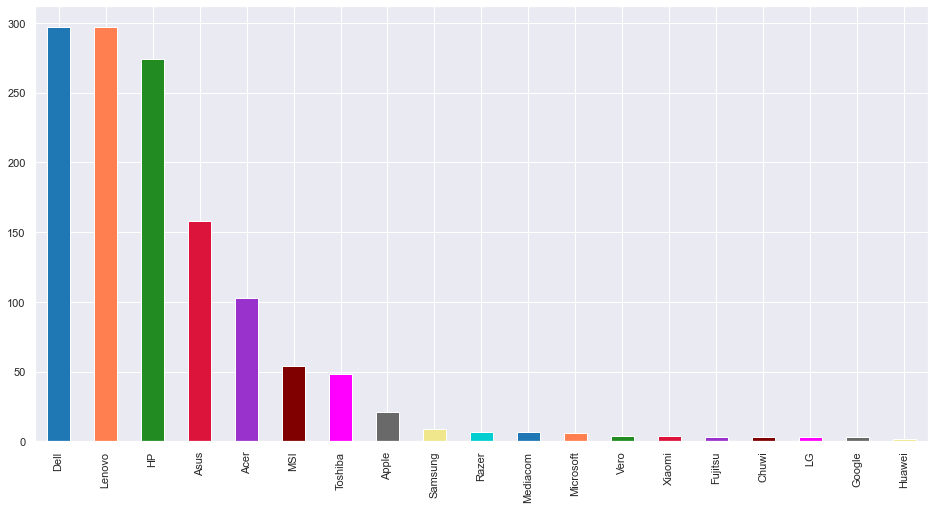

In [232]:
f = plt.figure(figsize=(16, 8))
laptopData['Company'].value_counts().head(100).plot.bar(color=colors)

<AxesSubplot:>

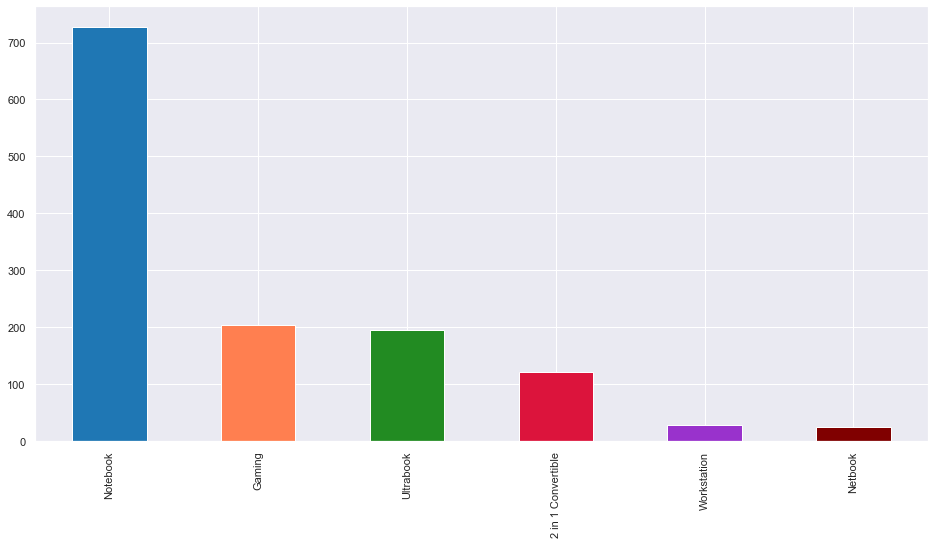

In [233]:
f = plt.figure(figsize=(16, 8))
laptopData['TypeName'].value_counts().head(100).plot.bar(color=colors)

<AxesSubplot:>

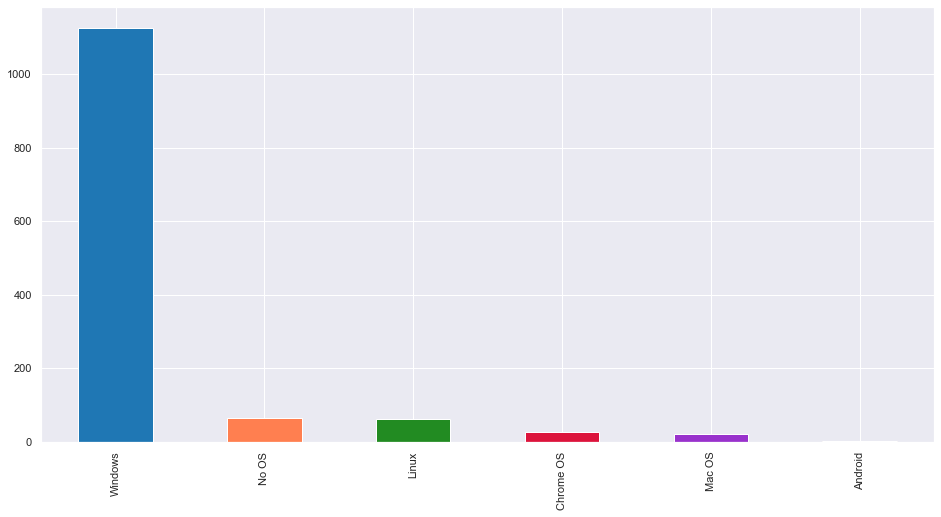

In [234]:
f = plt.figure(figsize=(16, 8))
laptopData['OpSys'].value_counts().head(100).plot.bar(color=colors)

<AxesSubplot:>

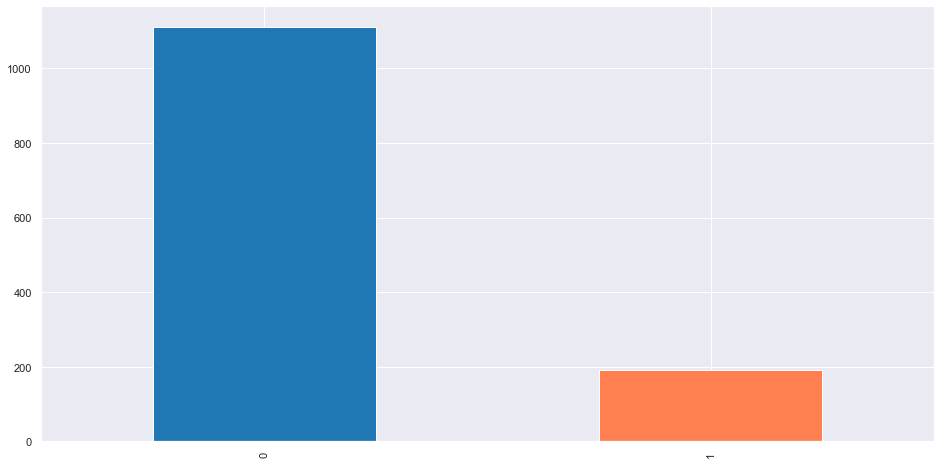

In [235]:
f = plt.figure(figsize=(16, 8))
laptopData['Touchscreen'].value_counts().head(100).plot.bar(color=colors)

<AxesSubplot:>

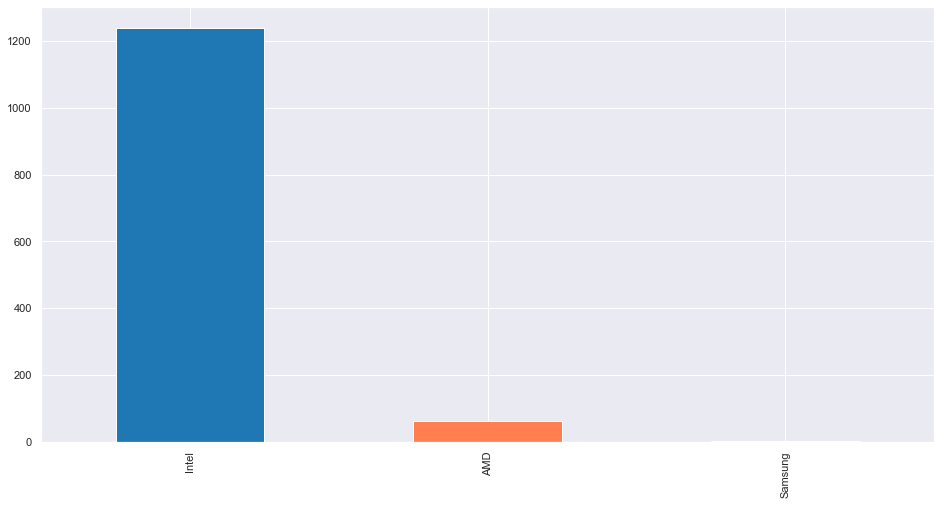

In [236]:
f = plt.figure(figsize=(16, 8))
laptopData['Cpu_Vender'].value_counts().head(100).plot.bar(color=colors)

<AxesSubplot:>

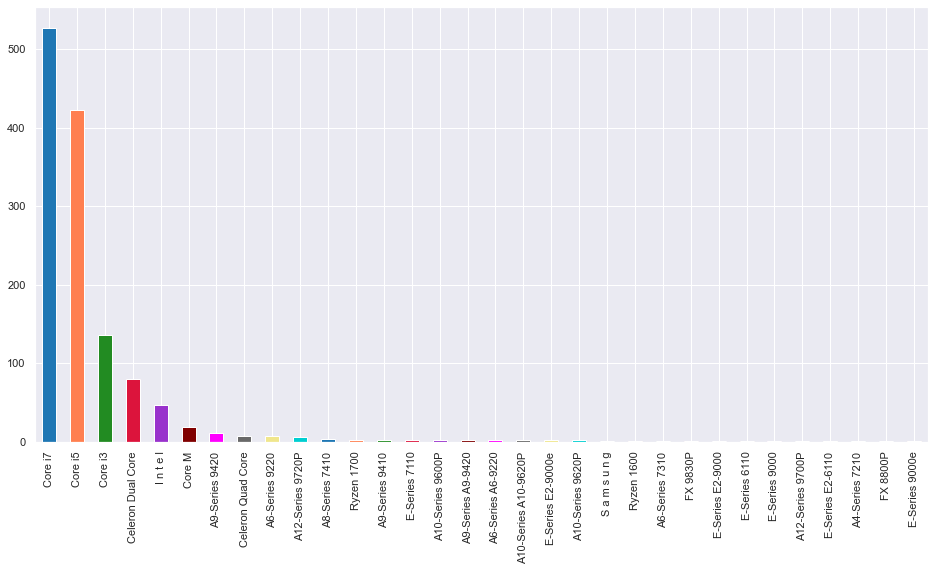

In [237]:
f = plt.figure(figsize=(16, 8))
laptopData['Cpu_Type'].value_counts().head(100).plot.bar(color=colors)

<AxesSubplot:>

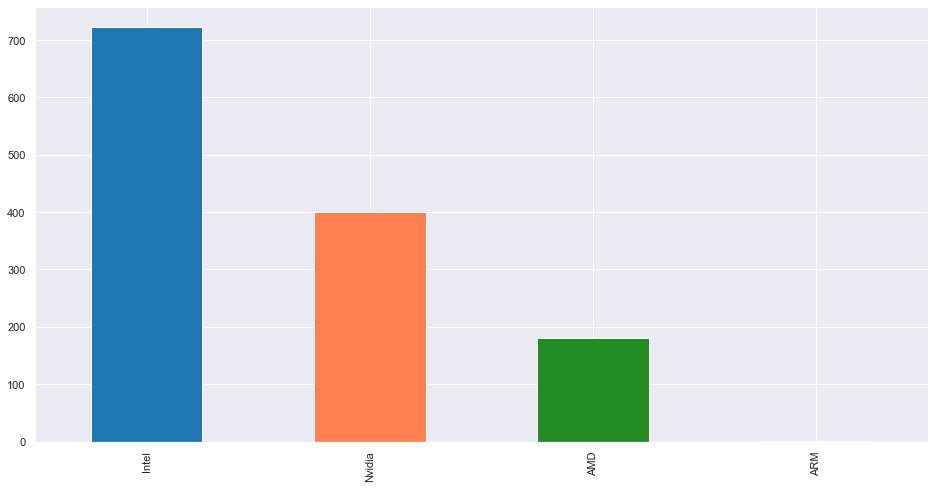

In [238]:
f = plt.figure(figsize=(16, 8))
laptopData['Gpu_Vender'].value_counts().head(100).plot.bar(color=colors)

<AxesSubplot:>

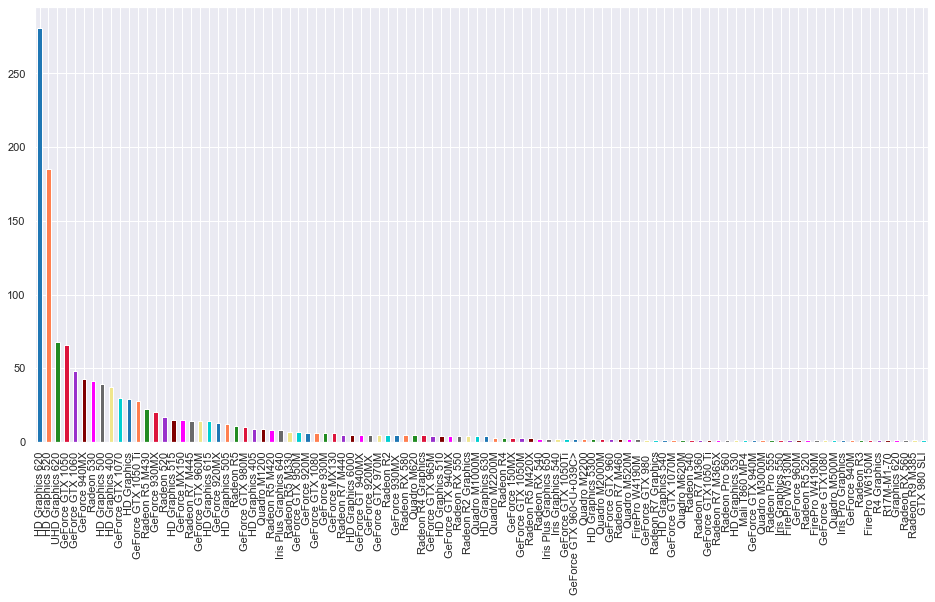

In [239]:
f = plt.figure(figsize=(16, 8))
laptopData['Gpu_Type'].value_counts().head(100).plot.bar(color=colors)

### Figure out the distribution of numerical variables

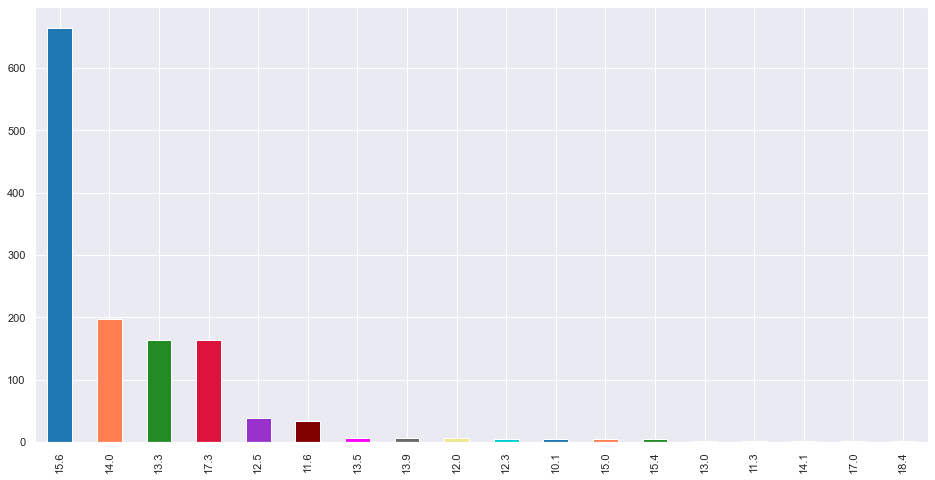

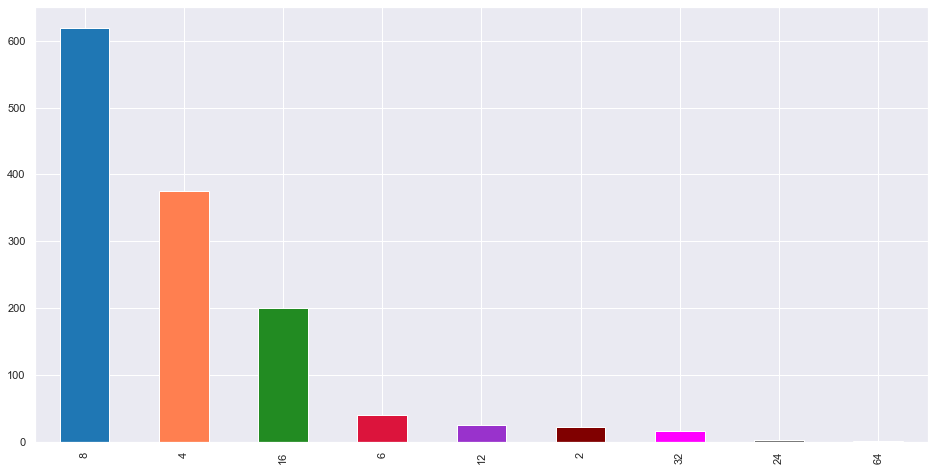

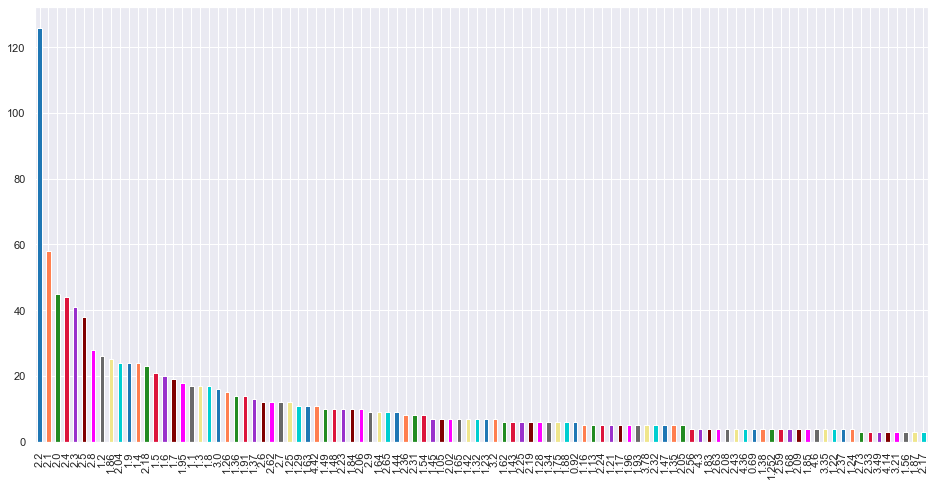

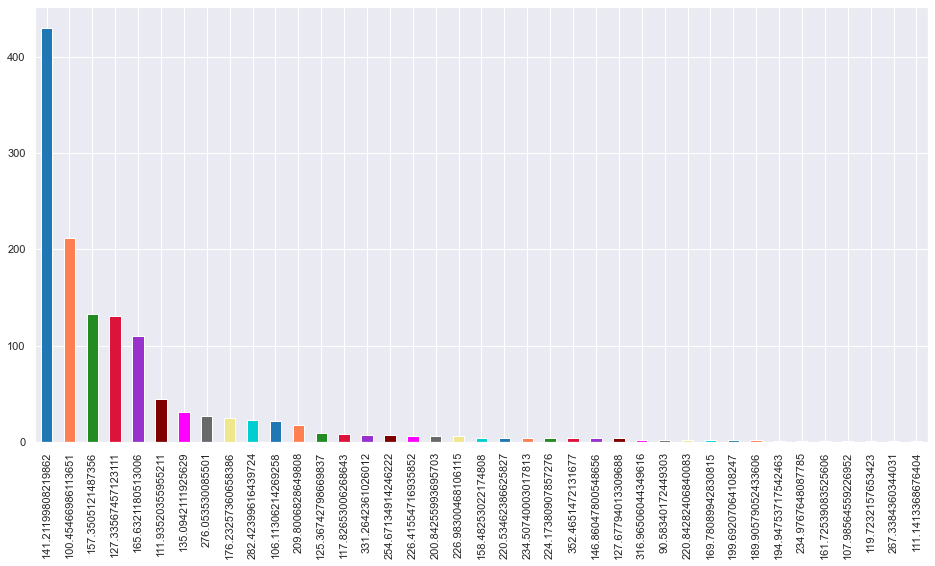

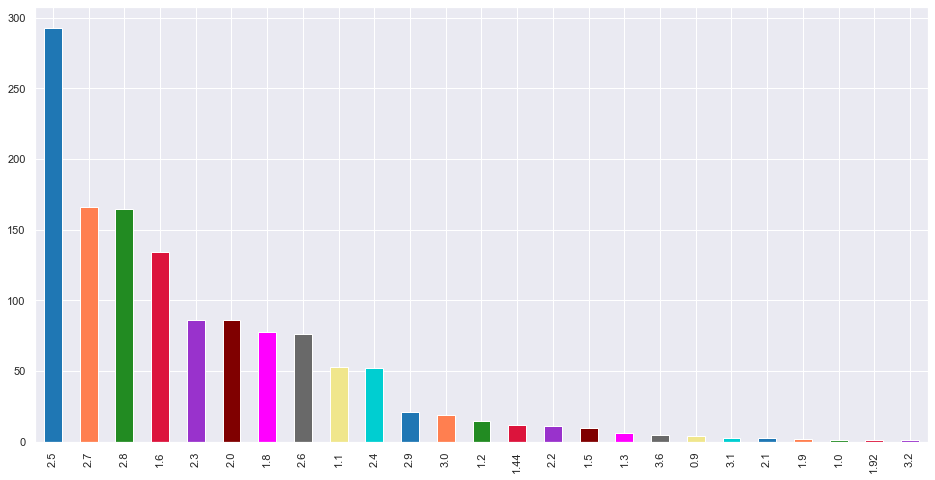

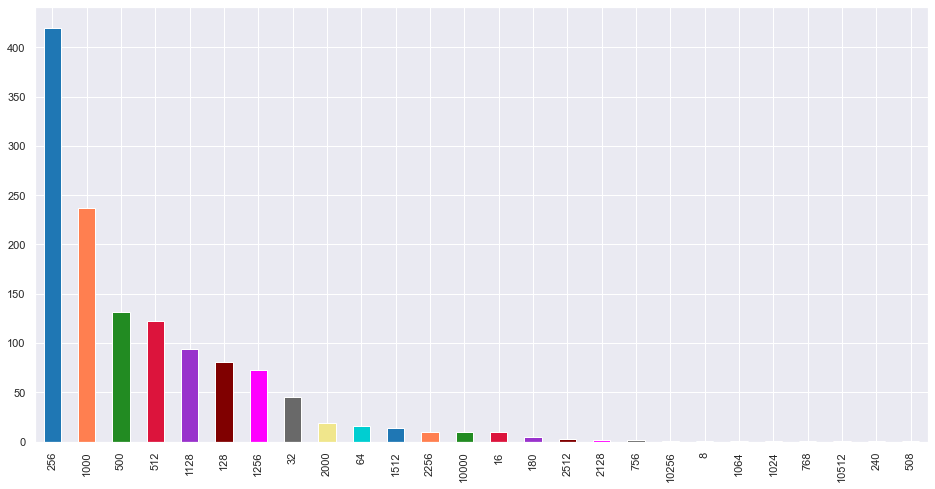

In [240]:
laptopData_num = pd.DataFrame(laptopData[['Inches', 'Ram', 'Weight', 'PPI', 'Cpu_Speed', 'Total_Memory']])

for var in laptopData_num:
    f = plt.figure(figsize=(16, 8))
    laptopData_num[var].value_counts().head(100).plot.bar(color=colors)

# Conclusion from Univariate Analysis in term of popularity:

### Company or Brand: Lenovo, Dell, HP are the top 3 laptop manufacturers;
### Laptop type: Notebook is the most dominant;
### Operation System: Windows is still the most used OS;
### Touch Screen: Much more non-touch screen laptops than touch screen laptops in current market; 
### Screen Size 15.6 inches and 8GB Ram is used for most laptop;
### CPU: Intel dominants the CPU market with Core i7/i5 and 2.5GHz is the most type; 
### GPU: Intel is also the largest player in GPU market but Nvidia is catching closer to Intel;
### Inches: 15.6 inches is most seen;
### Ram: 8GB is widest used;
### Weight: 2.2kg is the most;
### Memory: 256GB is installed in most laptops;

## Then, Let's take a look at basic statistic of "Price_euros"

In [241]:
priceData = laptopData['Price_euros']
priceData.head()

0    1339.69
1     898.94
2     575.00
3    2537.45
4    1803.60
Name: Price_euros, dtype: float64

In [242]:
priceData.describe().round(2)

count    1303.00
mean     1123.69
std       699.01
min       174.00
25%       599.00
50%       977.00
75%      1487.88
max      6099.00
Name: Price_euros, dtype: float64

<AxesSubplot:>

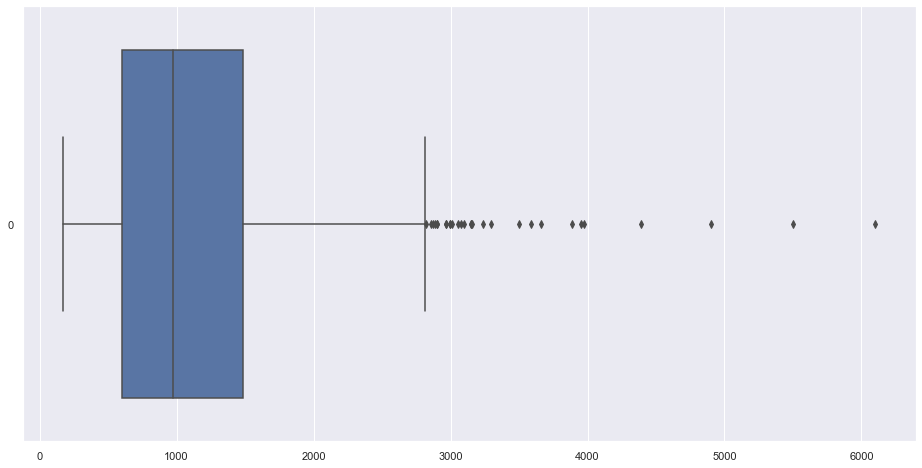

In [243]:
f = plt.figure(figsize=(16, 8))
sb.boxplot(data = priceData, orient = "h")

In [244]:
# Calculate the quartiles
Q1 = priceData.quantile(0.25)
Q3 = priceData.quantile(0.75)

# Formula to identify outliers
outliers = ((priceData < (Q1 - 1.5 * (Q3 - Q1))) | (priceData > (Q3 + 1.5 * (Q3 - Q1))))

# Count the number of outliers
outliers.sum()

29

<AxesSubplot:xlabel='Price_euros', ylabel='Count'>

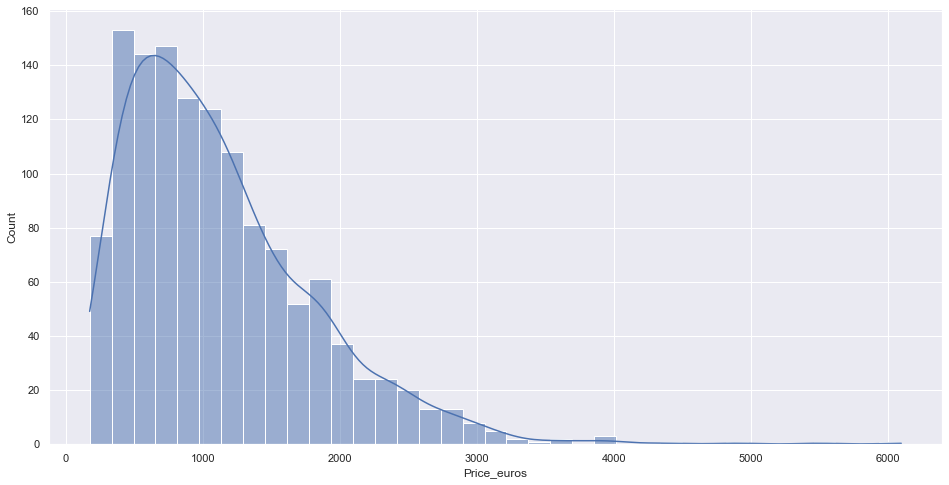

In [245]:
f = plt.figure(figsize=(16, 8))
sb.histplot(data = priceData, kde = True)

In [246]:
# Compute the skewness
priceData.skew() # positive skewness

1.5208655681688525

<AxesSubplot:>

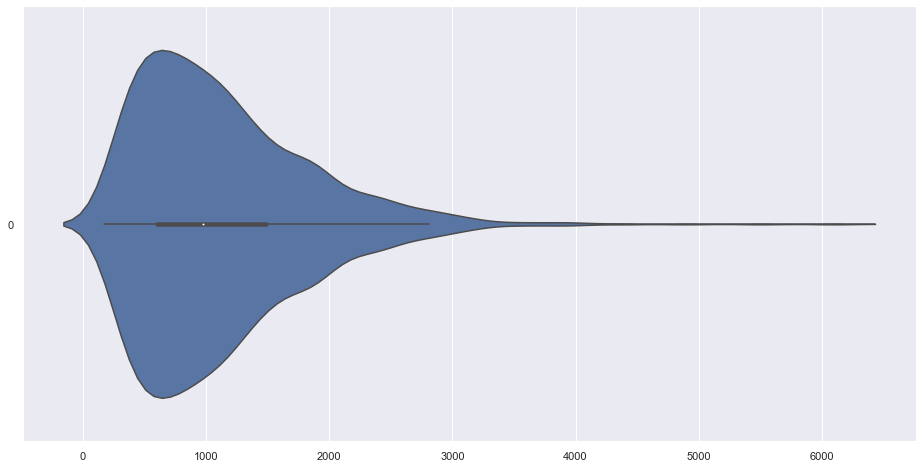

In [247]:
f = plt.figure(figsize=(16, 8))
sb.violinplot(data = priceData, orient = "h")

## Next, we would like to figure out the relationships between the categorical variables and price with Bi Variate Analysis

<Figure size 1152x576 with 0 Axes>

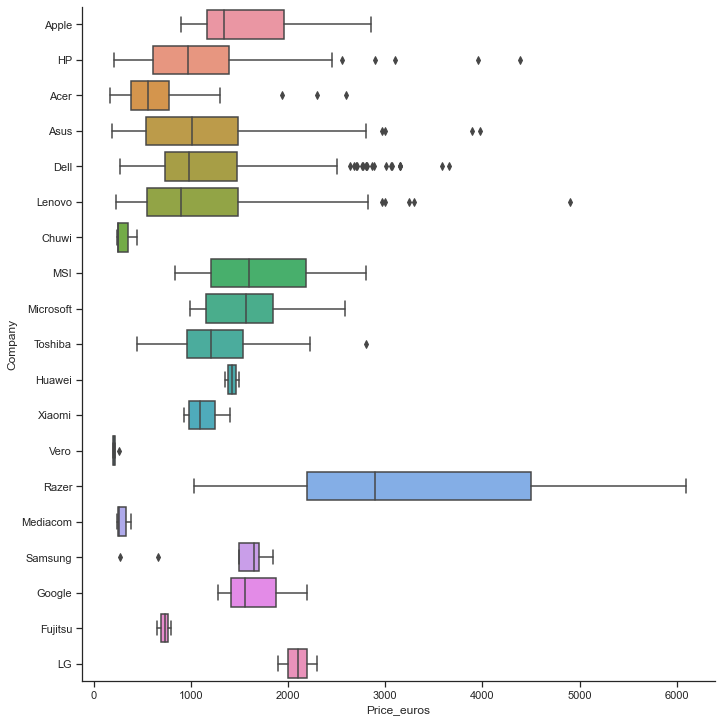

In [248]:
f = plt.figure(figsize=(16, 8))
sb.set_theme(style="ticks", color_codes=True)
sb.catplot(x="Price_euros", y="Company", kind="box", data=laptopData, height=10)

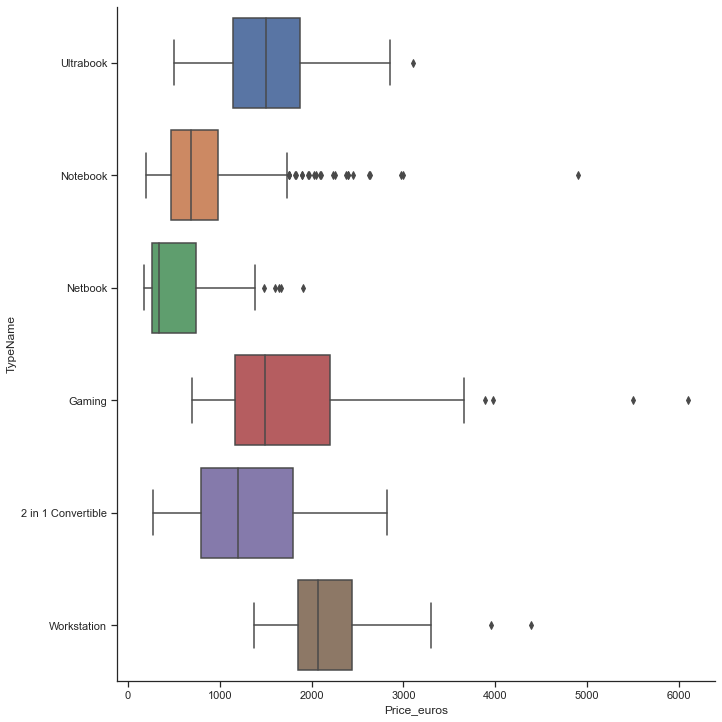

In [249]:
sb.catplot(x="Price_euros", y="TypeName", kind="box", data=laptopData, height=10)

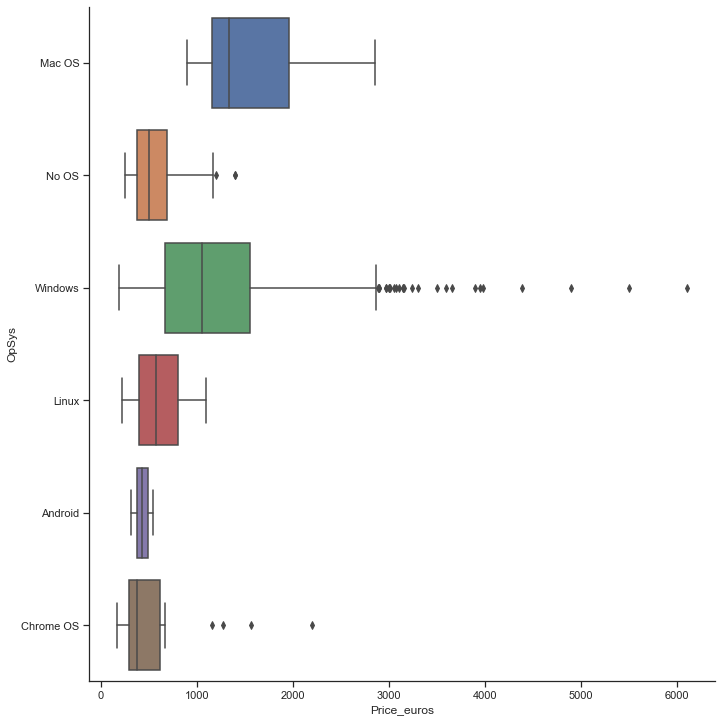

In [250]:
sb.catplot(x="Price_euros", y="OpSys", kind="box", data=laptopData, height=10)

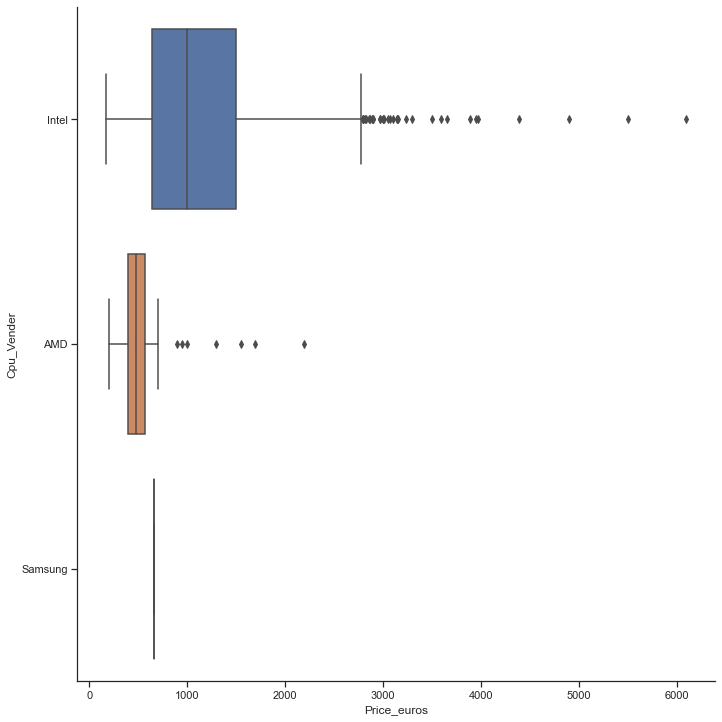

In [251]:
sb.catplot(x="Price_euros", y="Cpu_Vender", kind="box", data=laptopData, height=10)

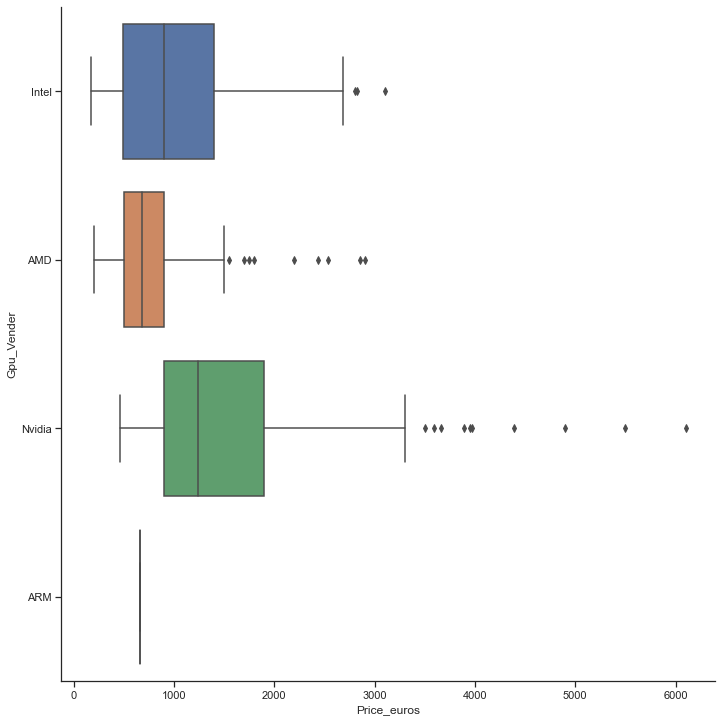

In [252]:
sb.catplot(x="Price_euros", y="Gpu_Vender", kind="box", data=laptopData, height=10)

## Conclusion from Bivariate Analysis (Categorical variables)
1. Even though MAC OS is least dominant OS in the market, the price of laptop using Mac OS tend to be on the higher end 
2. Many outliers can be observed for laptops using Windows OS. This outlier is likely coming from 'Razer' Company 
3. Majority of Laptop type 'Gaming Machine' & 'Work station' are on higher end price

## Lastly, proceed with Correlation Map Analysis (For Numerical Variables)

<AxesSubplot:>

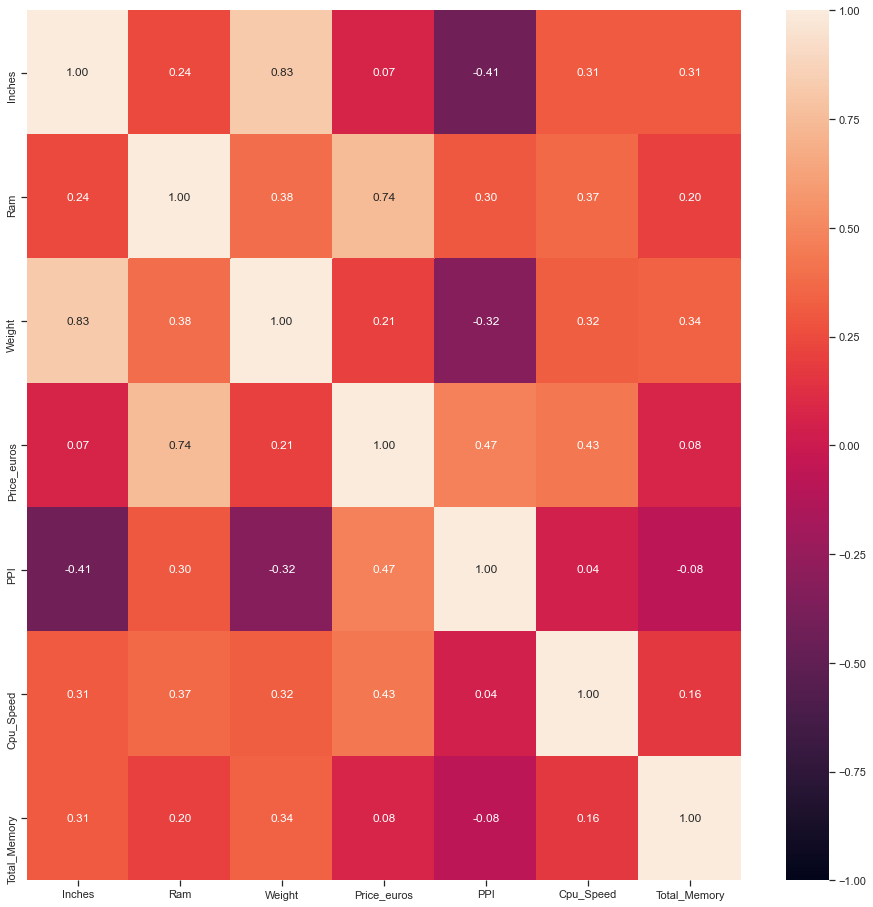

In [253]:
fig, ax = plt.subplots(figsize=(16,16))
sb.heatmap(laptopData.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

<AxesSubplot:>

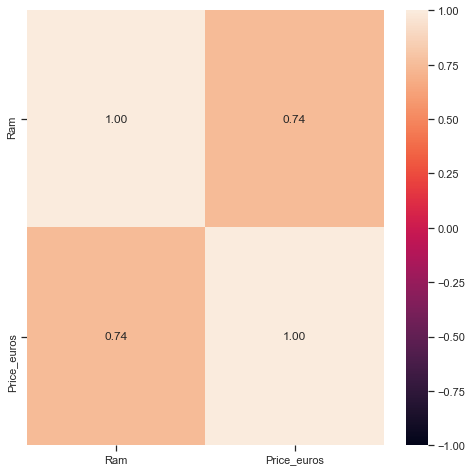

In [254]:
new1_laptopData = pd.DataFrame(laptopData[['Ram', 'Price_euros']])

fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(new1_laptopData.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

<AxesSubplot:>

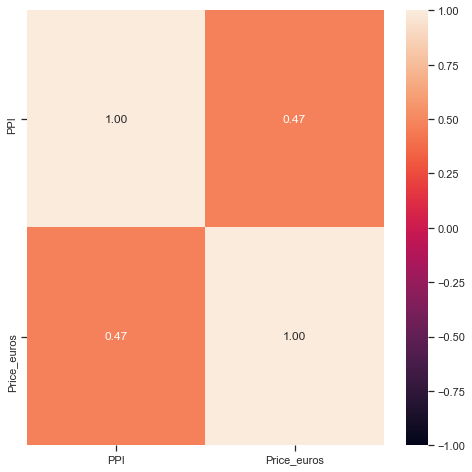

In [255]:
new2_laptopData = pd.DataFrame(laptopData[['PPI', 'Price_euros']])

fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(new2_laptopData.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

<AxesSubplot:>

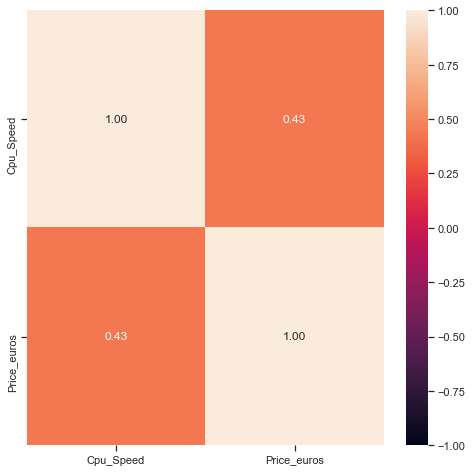

In [256]:
new3_laptopData = pd.DataFrame(laptopData[['Cpu_Speed', 'Price_euros']])

fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(new3_laptopData.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

## Observation:

1, Ram(0.74) , PPI(0.47) and Cpu_Speed(0.43) are the top 3 variables found to have higher positive correlation with Price_euros; 
2, Other numerical variables have much lesser impact on the price.

# Machine Learning 

## Model Used : Linear Regression

Linear Regression machine learning model is used to predict the laptop price. 
Ram, PPI and Cpu_Speed will be used as the response variables and Price_euros as the predictor.

Intercept of Regression 	: b =  [2.24463521]
Coefficients of Regression 	: a =  [[0.00547676]]


Predict Price_euro coresponding to Ram

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5351307733238617
Mean Squared Error (MSE) 	: 12.506287368279542

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6337335693948805
Mean Squared Error (MSE) 	: 7.856439400481506



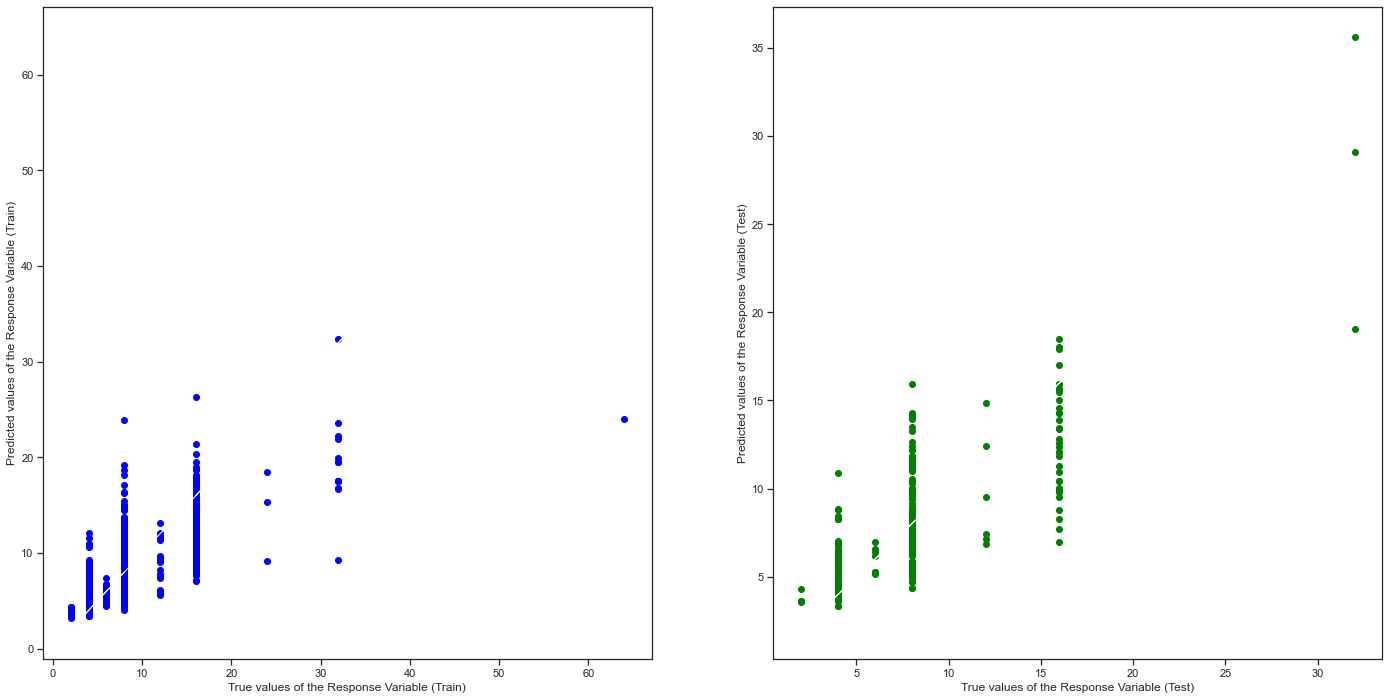

In [273]:
Response=pd.DataFrame(laptopData['Ram'])
Predictor=pd.DataFrame(laptopData['Price_euros'])


#Split the Dataset into Train and Test 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(Predictor, Response, test_size = 0.2)


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Price_Euro coresponding to Ram
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

print("\nPredict Price_euro coresponding to Ram\n")
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

Intercept of Regression 	: b =  [114.82700948]
Coefficients of Regression 	: a =  [[0.02825801]]


Predict Price_euro coresponding to PPI

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.22046310395403534
Mean Squared Error (MSE) 	: 1450.9224351179178

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.237890201400083
Mean Squared Error (MSE) 	: 1405.9662587108385



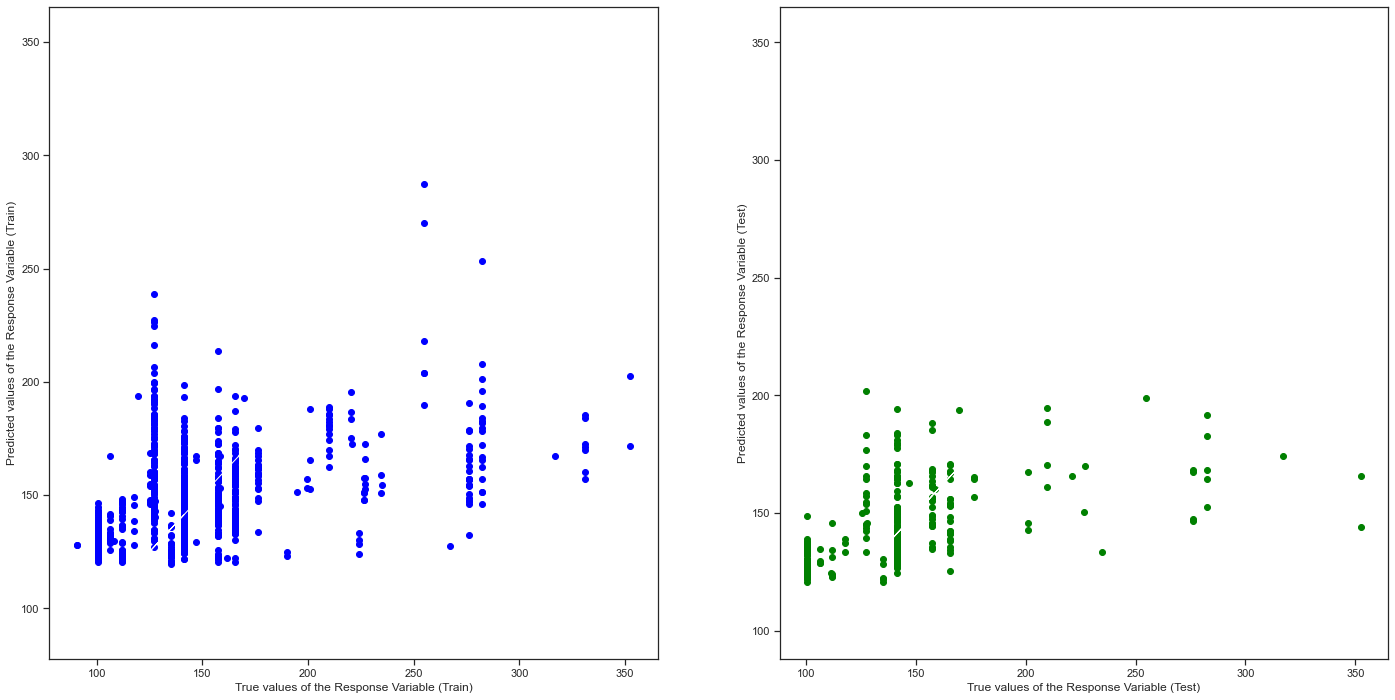

In [274]:
Response=pd.DataFrame(laptopData['PPI'])
Predictor=pd.DataFrame(laptopData['Price_euros'])


#Split the Dataset into Train and Test 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(Predictor, Response, test_size = 0.2)


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Price_Euro coresponding to SSD_GB
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

print("\nPredict Price_euro coresponding to PPI\n")
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

<ipython-input-275-e02e35dcf15b>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rmdtree_reg.fit(X_train, y_train) ## train the random forest regression model



Predict Price_Euro coresponding to PPI

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5428032215261672
Mean Squared Error (MSE) 	: 629.5862045111875

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.05072691358472725
Mean Squared Error (MSE) 	: 1874.419525198185



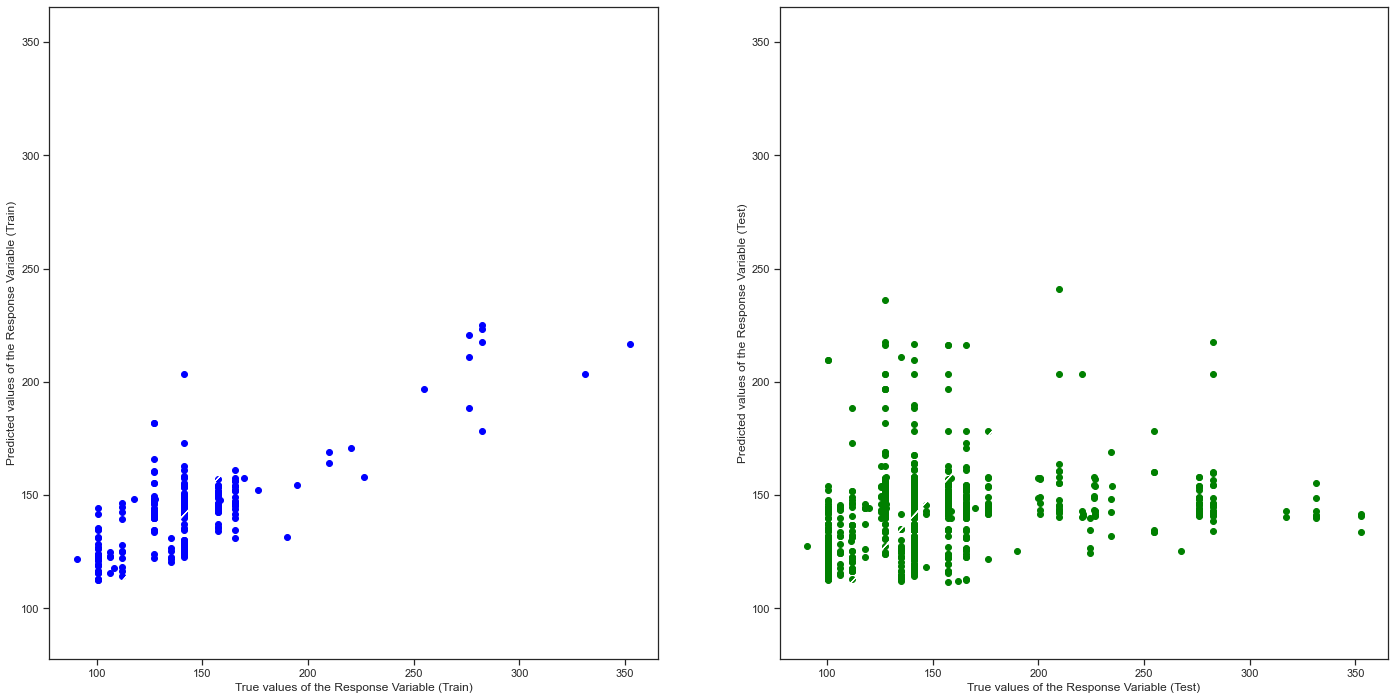

In [275]:
from sklearn.ensemble import RandomForestRegressor

Response=pd.DataFrame(laptopData['PPI'])
Predictor=pd.DataFrame(laptopData['Price_euros'])

#Split the Dataset into Train and Test 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(Predictor, Response, test_size = 0.8)

rmdtree_reg = RandomForestRegressor(max_depth=6) # create the random forest regression object
rmdtree_reg.fit(X_train, y_train) ## train the random forest regression model          

# Predict Price_Euro coresponding to PPI
y_train_pred = rmdtree_reg.predict(X_train)
y_test_pred = rmdtree_reg.predict(X_test)

print("\nPredict Price_Euro coresponding to PPI\n")
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rmdtree_reg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", rmdtree_reg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

Intercept of Regression 	: b =  [1.94914566]
Coefficients of Regression 	: a =  [[0.00031641]]


Predict Price_euro coresponding to Cpu_Speed

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.18234787524051577
Mean Squared Error (MSE) 	: 0.20739765317588715

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.19359954847344318
Mean Squared Error (MSE) 	: 0.21438262247782547



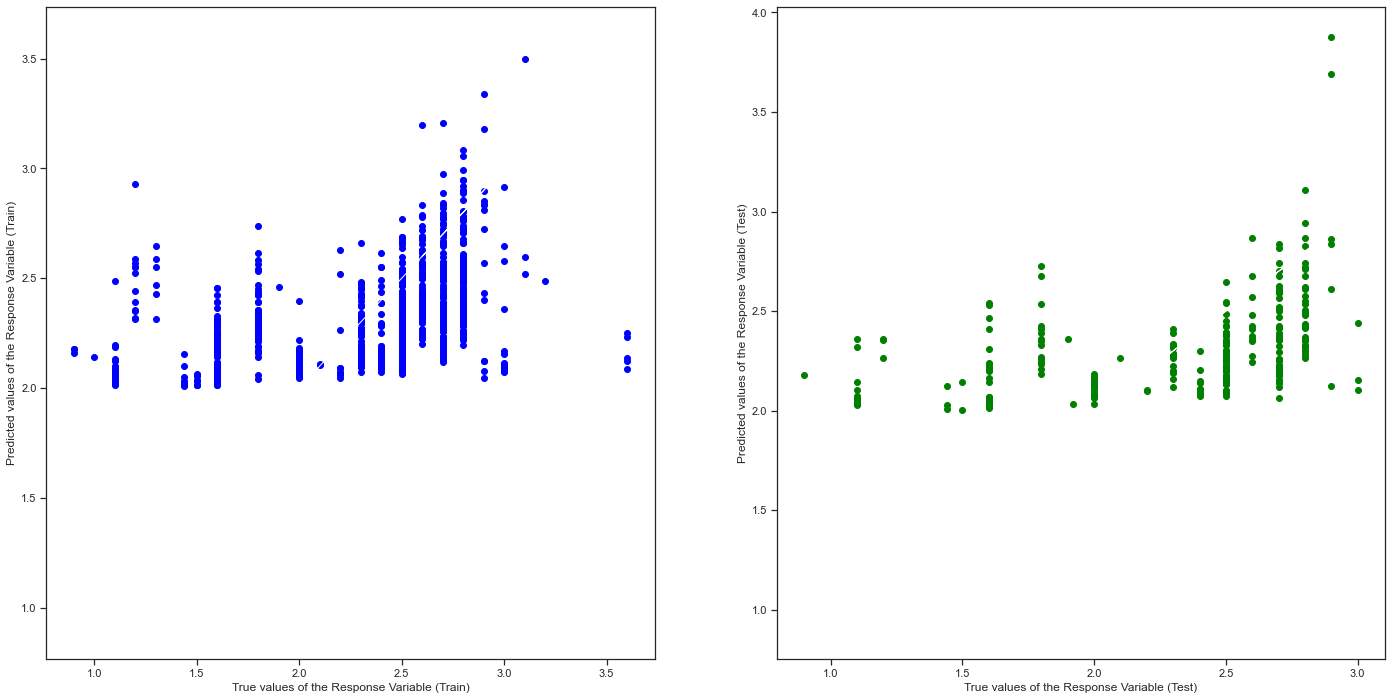

In [276]:
Response=pd.DataFrame(laptopData['Cpu_Speed'])
Predictor=pd.DataFrame(laptopData['Price_euros'])


#Split the Dataset into Train and Test 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(Predictor, Response, test_size = 0.2)


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Price_Euro coresponding to SSD_GB
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

print("\nPredict Price_euro coresponding to Cpu_Speed\n")
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

## Conclusion from Linear Regression & Random Forest Regression Models

1, It is observed that there is Goodness of fit model is around 50%, which is not high enough  to predict the price. Hence, linear regression model shouldn't be used for prediction; 
2, we import random forest model, which can increase the Explained Variance (R^2) to 80% above for training data, but no improvement for test data...

## Decision Tree Classification

In [284]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Function to categorize Price_euros
def categorize_price(pri):
    if(pri >= 977):
        return 'High'
    else:
        return 'Low'

laptopData['Price_euros'] = laptopData['Price_euros'].apply(categorize_price)

# Extract Response and Predictors
y = pd.DataFrame(laptopData['Price_euros'])
X = pd.DataFrame(laptopData[['Ram', 'PPI', 'Cpu_Speed']])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 6)  # create the decision tree object
dectree.fit(X_train, y_train)                # train the decision tree model

DecisionTreeClassifier(max_depth=6)

[Text(657.9209302325581, 1211.4514285714286, 'Ram <= 7.0\ngini = 0.5\nsamples = 1042\nvalue = [521, 521]\nclass = N'),
 Text(303.65581395348835, 1025.074285714286, 'Cpu_Speed <= 2.15\ngini = 0.147\nsamples = 350\nvalue = [28, 322]\nclass = Y'),
 Text(272.51162790697674, 838.6971428571429, 'gini = 0.0\nsamples = 175\nvalue = [0, 175]\nclass = Y'),
 Text(334.8, 838.6971428571429, 'PPI <= 152.105\ngini = 0.269\nsamples = 175\nvalue = [28, 147]\nclass = Y'),
 Text(202.43720930232558, 652.32, 'PPI <= 126.352\ngini = 0.195\nsamples = 146\nvalue = [16, 130]\nclass = Y'),
 Text(124.57674418604651, 465.9428571428572, 'PPI <= 109.024\ngini = 0.285\nsamples = 87\nvalue = [15, 72]\nclass = Y'),
 Text(62.288372093023256, 279.5657142857142, 'Cpu_Speed <= 2.45\ngini = 0.058\nsamples = 67\nvalue = [2, 65]\nclass = Y'),
 Text(31.144186046511628, 93.18857142857155, 'gini = 0.0\nsamples = 26\nvalue = [0, 26]\nclass = Y'),
 Text(93.43255813953488, 93.18857142857155, 'gini = 0.093\nsamples = 41\nvalue = [2

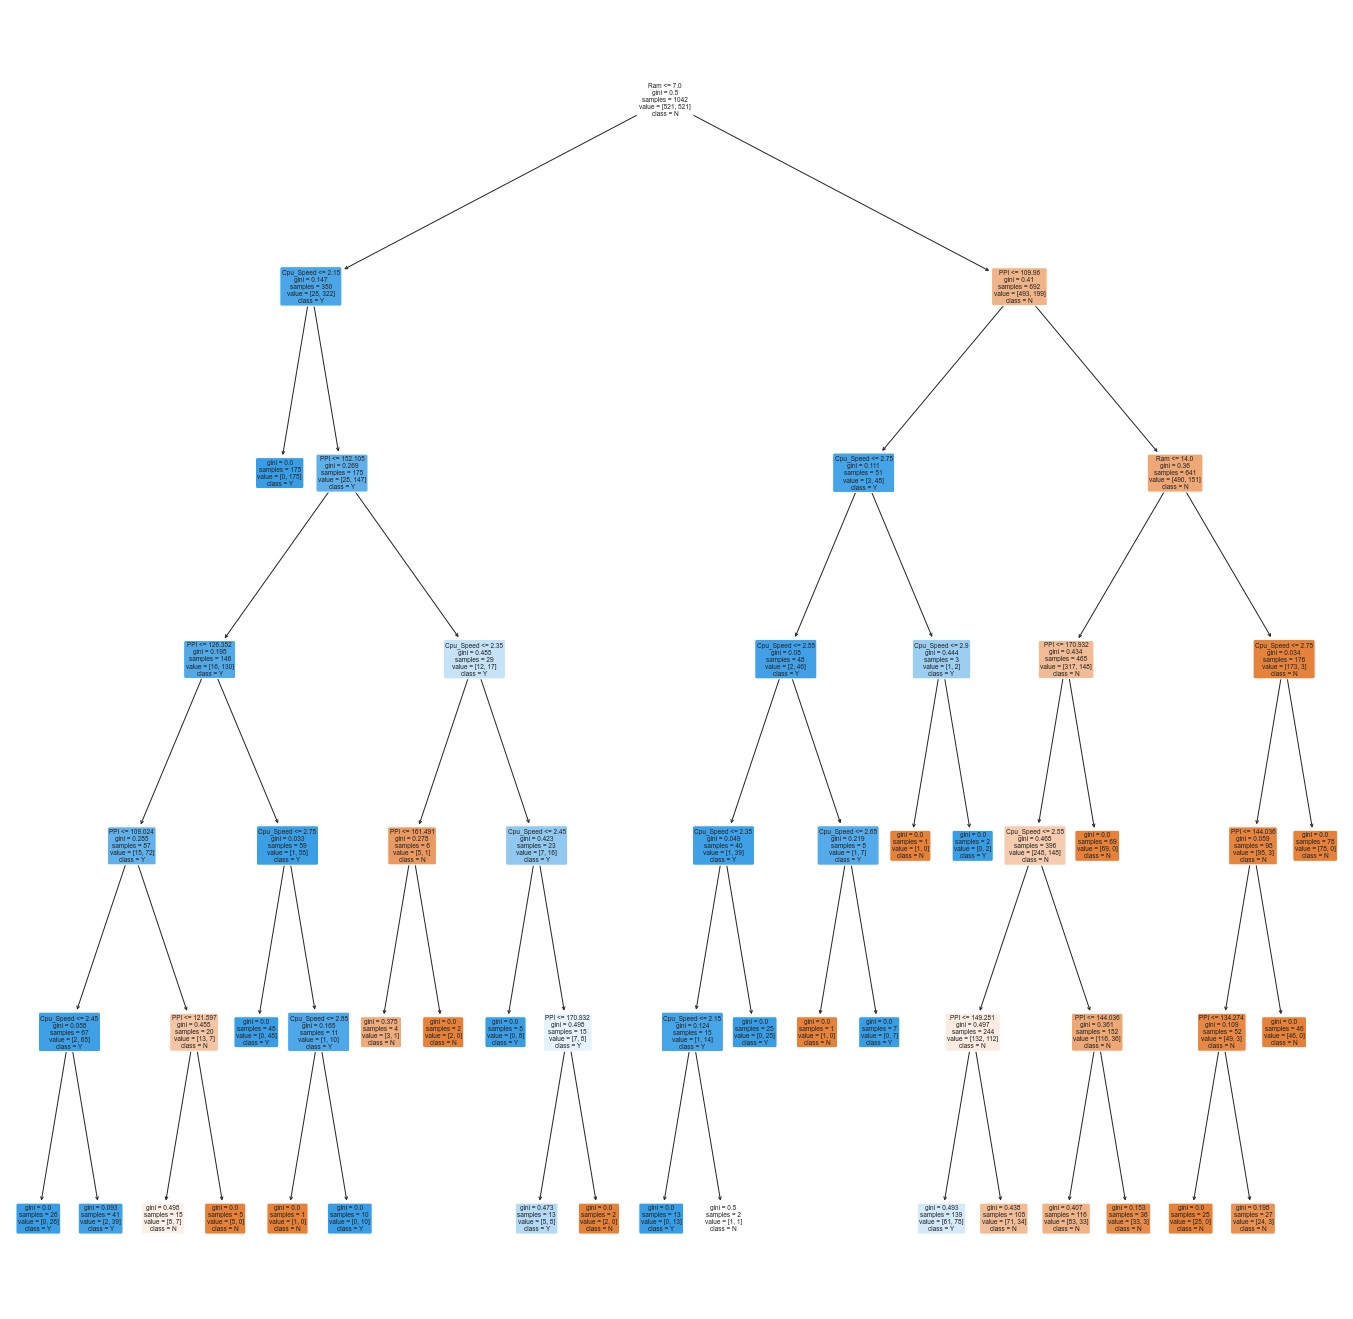

In [285]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["N","Y"])

Train Data
Accuracy  :	 0.8560460652591171

TPR Train :	 0.8426103646833013
TNR Train :	 0.8694817658349329

FPR Train :	 0.13051823416506717
FNR Train :	 0.15738963531669867


<AxesSubplot:>

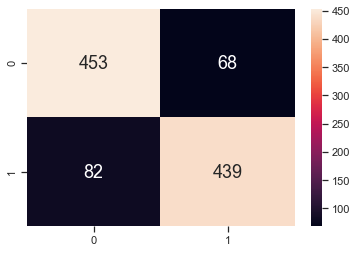

In [286]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Y (1) predicted Y (1)
fpTrain = cmTrain[0][1] # False Positives : N (0) predicted Y (1)
tnTrain = cmTrain[0][0] # True Negatives : N (0) predicted N (0)
fnTrain = cmTrain[1][0] # False Negatives : Y (1) predicted N (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Model Used : KNN (Still exploring)

In [ ]:
X = laptopData.drop(['Price_euros'],axis=1)
Y = laptopData['Price_euros'].values
X = X.select_dtypes(exclude=['object'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=33)
X

In [ ]:
Kreg = KNeighborsRegressor()
Kreg.fit(X_train, y_train)
pred = Kreg.predict(X_train)
print("Mean Square Error (MSE):", mean_squared_error(y_train, pred))

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 12, 2),
              'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(Kreg, param_grid)
grid_search.fit(X_train, y_train)
print("Best score: " + str(grid_search.best_score_))

In [ ]:
final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_test)
final_pred = final_pred.tolist()
for pred in range(0, len(final_pred)):
    print("Predicition: " + str(round(final_pred[pred], 2)) + " Actual: " + str(y_test[pred]))

In [ ]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax.scatter(y_test, final_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# END OF NOTEBOOK